### Lab 1: Measure Distance to Pluto

<!-- Below are the steps to reduce data:
1. Stack bias frames to compute median frame
2. Subtract bias frame from dark frame and stack to compute median frame
3. $\rm~Flat_{\rm~{dome}} = \frac{flat_{\rm~}}{}$ -->

In [32]:
import os 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
import astroalign

In [2]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\Pluto"

In [3]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    if f != "pluto_night1.fits" or f != "pluto_night2.fits":
        hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [4]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

bias_frames_n1 = hdu_lst[np.where(obj_lst=='bias_')]
dark_frames_n1 = hdu_lst[np.where(obj_lst=='dark_')]

bias_frames_n2 = hdu_lst[np.where(obj_lst=='bias AR')]
dark_frames_n2 = hdu_lst[np.where(obj_lst=='darks 10 AR')]

dome_flat_frames = hdu_lst[np.where(obj_lst=='flat_dome_R_')]

pluto_frames_n1 =hdu_lst[np.where(obj_lst=='pluto')]
pluto_frames_n2 = hdu_lst[np.where(obj_lst=='pluto 10 R')]


In [22]:
def reduce_data(bias, dark, dome_flat, science):
    """ Performs all data reduction steps and returns reduced science frame
    """

    # Median Bias Frames
    bias_full = np.median(np.stack([b.data for b in bias]),axis=0)
    print(np.median(bias_full))
    # Median Dark Frames 
    dark_exptime = dark[0].header['EXPTIME']
    dark_full = np.median(np.stack([(b.data - bias_full) for b in dark]),axis=0)

    # Median Dome Flats
    df_exptime = dome_flat[0].header['EXPTIME']
    dome_flat_full = np.median(np.stack([( (b.data/df_exptime) \
                                        - (dark_full/dark_exptime) )/np.median(b.data) for b in dome_flat]), axis=0)

    # Median Science Frames
    sci_exptime = science[0].header['EXPTIME']
    sci_full = np.median(np.stack([((b.data/sci_exptime) - (dark_full/dark_exptime))/dome_flat_full for b in science]), axis=0)

    print(f"Exposure Times:\nDome Flat - {df_exptime}s\nDark - {dark_exptime}s\nScience - {sci_exptime}s\n")
    return sci_full
    

In [23]:
sci_n1 = reduce_data(bias_frames_n1, dark_frames_n1, dome_flat_frames, pluto_frames_n1)
sci_n2 = reduce_data(bias_frames_n2, dark_frames_n2, dome_flat_frames, pluto_frames_n2)

1047.0
Exposure Times:
Dome Flat - 10s
Dark - 15s
Science - 15s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 10s



In [24]:
# # Median Bias Frames
# bias_frame_n1 = np.median(np.stack([b.data for b in bias_frames_n1]),axis=0)
# bias_frame_n2 = np.median(np.stack([b.data for b in bias_frames_n2]),axis=0)

# # Median Dark Frames 
# dark_exptime_n1 = dark_frames_n1[0].header['EXPTIME']
# dark_image_n1 = np.median(np.stack([(b.data - bias_frame_n1) for b in dark_frames_n1]),axis=0)

# dark_exptime_n2 = dark_frames_n2[0].header['EXPTIME']
# dark_image_n2 = np.median(np.stack([(b.data - bias_frame_n2) for b in dark_frames_n2]),axis=0)

# # Median Dome Flats
# bf_exptime = dome_flat_frames[0].header['EXPTIME']
# dome_flat_frame_n1 = np.median(np.stack([( ((b.data - bias_frame_n1)/bf_exptime) \
#                                        - (dark_image_n1/dark_exptime_n1) )/np.median(b.data) for b in dome_flat_frames]), axis=0)

# dome_flat_frame_n2 = np.median(np.stack([( ((b.data - bias_frame_n1)/bf_exptime) \
#                                        - (dark_image_n1/dark_exptime_n1) )/np.median(b.data) for b in dome_flat_frames]), axis=0)

# # # Median Dark Flats
# # df_exptime = twiflat_R_frames[0].header['EXPTIME'] 
# # dark_flat_frame = np.median(np.stack([(b.data - bias_frame)/df_exptime for b in twiflat_R_frames]),axis=0)

In [25]:
# # Night 1 science frame 
# pluto_exptime1 = pluto_frames_n1[0].header['EXPTIME']
# sci_frame_n1 = np.median(np.stack([(b.data - dark_image_n1 - bias_frame_n1)/ dome_flat_frame_n1 for b in pluto_frames_n1]), axis=0)

# # Night 2 science frame 
# pluto_exptime2 = pluto_frames_n2[0].header['EXPTIME']
# sci_frame_n2 = np.median(np.stack([(b.data - dark_image_n1 - bias_frame_n1)/ dome_flat_frame_n2 for b in pluto_frames_n2]), axis=0)

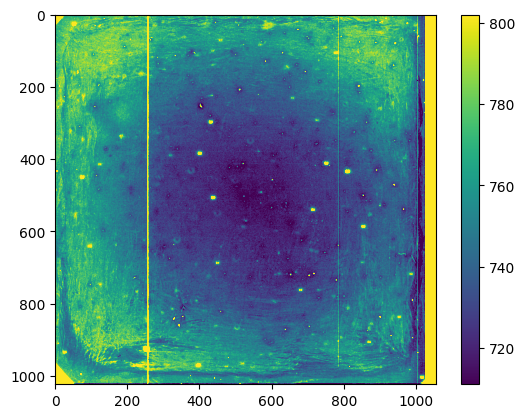

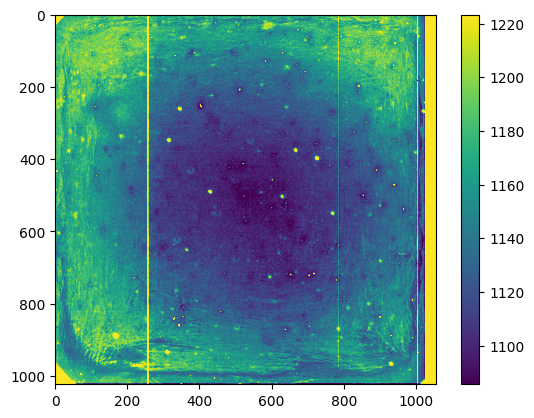

In [28]:
#res = (sci_frame - dark_image) / dome_flat_frame
res1 = sci_n1 # sci_frame_n1
res2 = sci_n2
plt.figure()
plt.imshow(res1, vmin=np.percentile(res1, 2), vmax=np.percentile(res1, 96))
plt.colorbar()

plt.figure()
plt.imshow(res2, vmin=np.percentile(res2, 2), vmax=np.percentile(res2, 96))
plt.colorbar()

In [39]:
sci_n2 = astroalign.register(sci_n1, sci_n2, max_control_points= 1, 
                             detection_sigma = 1, min_area = 1
                        )

ValueError: Reference stars in source image are less than the minimum value (3).

save science frames to fits files, 

In [30]:
save_dir = 'c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\'

In [31]:
# Save to fits
fits.writeto(os.path.join(save_dir,'pluto_night1V2.fits'),res1, overwrite=True)
fits.writeto(os.path.join(save_dir,'pluto_night2V2.fits'),res2, overwrite=True)